In [10]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display

# Oxford
`OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries`

| Cell ID                                | Anode    | Cathode | Source  | Ah   | Form Factor | Temperature (C) | Max SOC | Min SOC | Charge Rate (C) | Discharge Rate (C) |
|----------------------------------------|----------|---------|---------|------|-------------|-----------------|---------|---------|-----------------|--------------------|
| OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries | graphite | LCO     | oxford  | 0.74 | pouch       | 40.00           | 100.00  | 0.00    | 2.00            | 1.84               |

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [2]:
# Header: Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('Battery_Archive_Data/Oxford/OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
df = df[df['Cell_Temperature (C)'] >= 1]

display(df)
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
1,1.0,9.990000e-01,-0.74,4.175,0.000,40.051
2,1.0,1.999000e+00,-0.74,4.174,0.000,39.988
3,1.0,2.999000e+00,-0.74,4.172,0.000,39.976
4,1.0,3.999000e+00,-0.74,4.171,0.000,39.964
5,1.0,4.999000e+00,-0.74,4.170,0.001,39.988
...,...,...,...,...,...,...
457802,8200.0,5.517855e+07,-0.74,3.336,0.528,41.249
457803,8200.0,5.517855e+07,-0.74,3.335,0.528,41.237
457804,8200.0,5.517855e+07,-0.74,3.333,0.528,41.199
457805,8200.0,5.517855e+07,-0.74,3.332,0.529,41.224


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,227455.000000,2.274550e+05,2.274550e+05,227455.000000,227455.000000,227455.000000
mean,3967.207615,2.669858e+07,-7.400000e-01,3.765557,0.305788,40.523928
std,2444.986810,1.680400e+07,2.220451e-16,0.195065,0.179824,0.470356
min,1.000000,9.990000e-01,-7.400000e-01,2.699000,0.000000,39.614000
25%,1900.000000,1.224665e+07,-7.400000e-01,3.656000,0.151000,40.113000
50%,3900.000000,2.608378e+07,-7.400000e-01,3.759000,0.303000,40.400000
75%,6100.000000,4.162771e+07,-7.400000e-01,3.902000,0.455000,40.912000
max,8200.000000,5.517871e+07,-7.400000e-01,4.176000,0.741000,41.699000


## Visualização

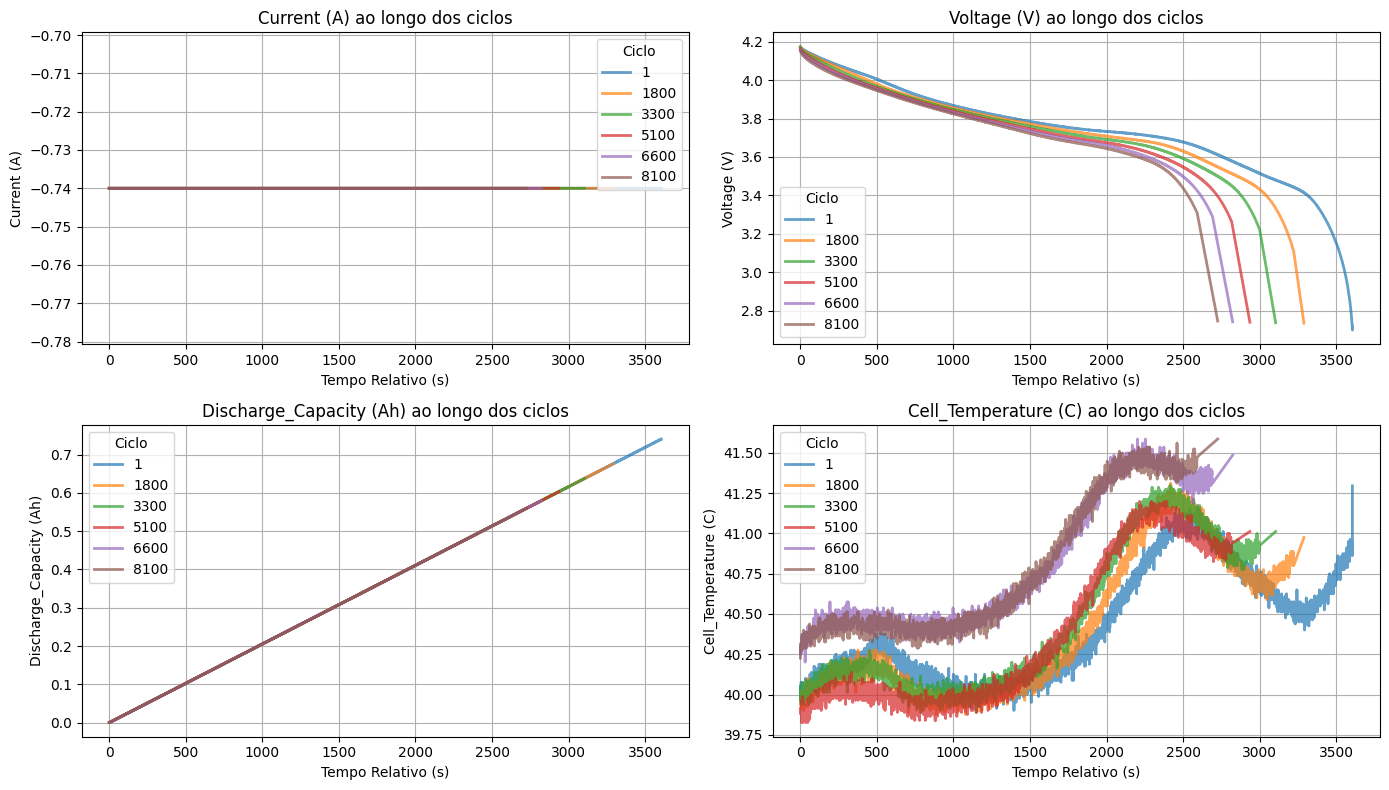

In [3]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)

    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()


## SOH no decorrer dos ciclos

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

- $CapacidadeInicial$ é a capacidade nominal, a maior considerando todo o histórico da bateria
- $CapacidadeAtual$ é a maior capacidade do ciclo

In [4]:
# Capacidade nominal (máxima global)
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

# para cada ciclo, extrai a maior capacidade 
# (cycles_capacity é uma série do Pandas)
cycles_capacity = df.groupby('Cycle_Index')['Discharge_Capacity (Ah)'].max()
cycles_capacity = cycles_capacity.reset_index() # transforma em dataframe
cycles_capacity.columns = ['Cycle_Index', 'Max_Discharge_Capacity']
cycles_capacity['SOH_discharge'] = (cycles_capacity['Max_Discharge_Capacity'] / nominal_capacity)
display(cycles_capacity)


Capacidade total de descarga: 0.741 Ah


,Cycle_Index,Max_Discharge_Capacity,SOH_discharge
0,1.0,0.741,1.000000
1,100.0,0.732,0.987854
2,200.0,0.728,0.982456
3,300.0,0.725,0.978408
4,400.0,0.720,0.971660
...,...,...,...
72,7800.0,0.564,0.761134
73,7900.0,0.564,0.761134
74,8000.0,0.563,0.759784
75,8100.0,0.560,0.755735


In [5]:
# Definir os valores de capacidade total
# valor maximo de capacidade de descarga
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

df_grouped = df.groupby('Cycle_Index', as_index=False).mean()
df_grouped = df_grouped.drop(columns=['Test_Time (s)'])

# Adição do SOH calculado em ciclos_capacity
df_grouped['SOH_discharge'] = cycles_capacity['SOH_discharge']
display(df_grouped)
display(df_grouped.describe())

Capacidade total de descarga: 0.741 Ah


,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge
0,1.0,-0.74,3.734169,0.370422,40.419166,1.000000
1,100.0,-0.74,3.747943,0.360354,40.319742,0.987854
2,200.0,-0.74,3.753684,0.355627,40.317441,0.982456
3,300.0,-0.74,3.755413,0.353264,40.311226,0.978408
4,400.0,-0.74,3.754933,0.351824,40.304815,0.971660
...,...,...,...,...,...,...
72,7800.0,-0.74,3.772130,0.268272,40.733336,0.761134
73,7900.0,-0.74,3.772726,0.266834,40.738304,0.761134
74,8000.0,-0.74,3.771303,0.266834,40.720570,0.759784
75,8100.0,-0.74,3.772765,0.266113,40.774364,0.755735


,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge
count,77.000000,7.700000e+01,77.000000,77.000000,77.000000,77.000000
mean,4188.324675,-7.400000e-01,3.766212,0.303210,40.537653,0.847942
std,2448.283784,1.187854e-16,0.007558,0.028160,0.178534,0.069428
min,1.000000,-7.400000e-01,3.734169,0.264266,40.227923,0.755735
25%,2200.000000,-7.400000e-01,3.761675,0.278960,40.379861,0.788124
50%,4200.000000,-7.400000e-01,3.768656,0.298691,40.470904,0.835358
75%,6300.000000,-7.400000e-01,3.771884,0.323048,40.733336,0.896086
max,8200.000000,-7.400000e-01,3.778072,0.370422,40.801851,1.000000


In [6]:
# Inicialmente, thresholder é primeiro valor de SOH_discharge
# A cada queda de 0,01 atingida, é atualizado
last_cycle           = df_grouped["Cycle_Index"][0]
soh_initial          = df_grouped["SOH_discharge"][0]
thresholder          = soh_initial - 0.01

cycles_between_drops = []
drop_cycles          = []

# Percorre as linhas do dataframe a partir da segunda linha
for index, row in df_grouped.iterrows():
    while row["SOH_discharge"] <= thresholder:
        # Calcular a diferença de ciclos desde a última queda registrada
        cycles_between_drops.append(row["Cycle_Index"] - last_cycle)
        drop_cycles.append(row["Cycle_Index"])
        
        # Atualiza a referência de última queda para o ciclo atual
        last_cycle = row["Cycle_Index"]
        
        # Atualiza para a próxima queda de 1%
        thresholder -= 0.01

print("Ciclos com quedas de 1%:", drop_cycles, end='\n\n- - - - - - - - - - -\n\n')
print("Ciclos entre cada queda:", cycles_between_drops)

Ciclos com quedas de 1%: [100.0, 300.0, 500.0, 700.0, 900.0, 1100.0, 1400.0, 1800.0, 1900.0, 2200.0, 2400.0, 2700.0, 3000.0, 3500.0, 3700.0, 4100.0, 4500.0, 5000.0, 5200.0, 5800.0, 6300.0, 6900.0, 7400.0, 8000.0]

- - - - - - - - - - -

Ciclos entre cada queda: [99.0, 200.0, 200.0, 200.0, 200.0, 200.0, 300.0, 400.0, 100.0, 300.0, 200.0, 300.0, 300.0, 500.0, 200.0, 400.0, 400.0, 500.0, 200.0, 600.0, 500.0, 600.0, 500.0, 600.0]


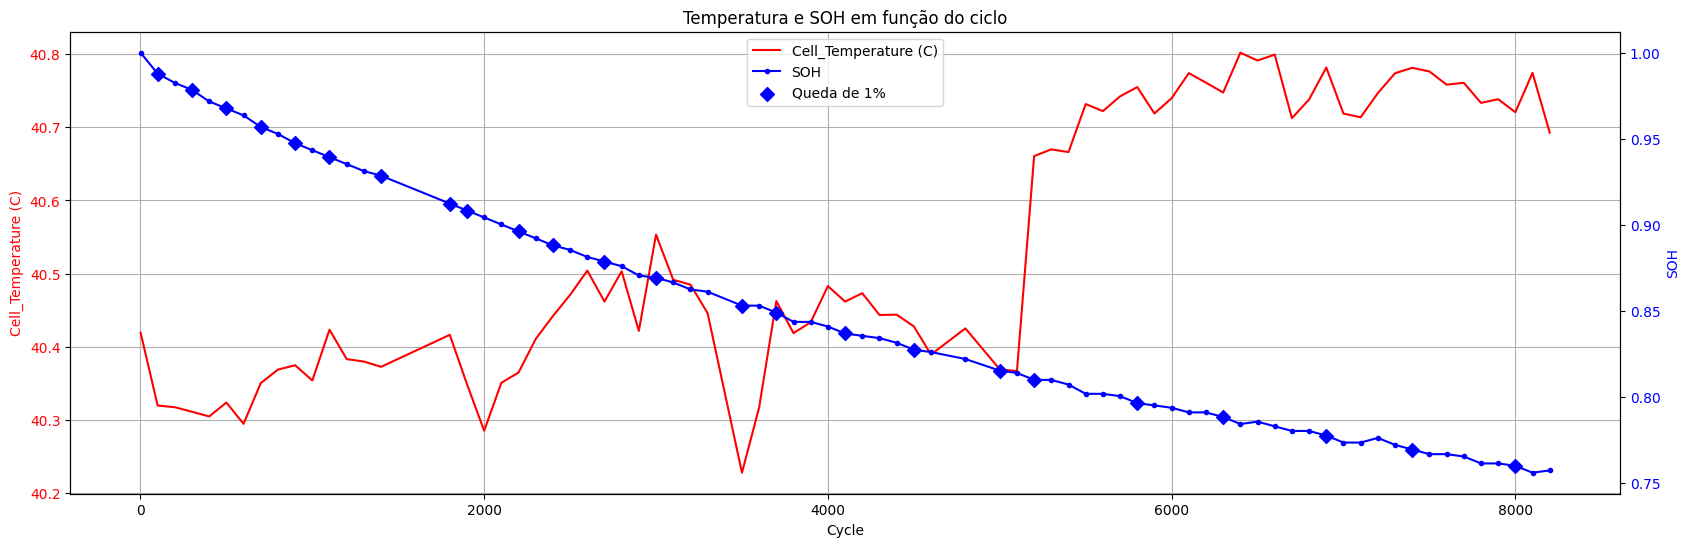

In [7]:
fig, ax1 = plt.subplots(figsize=(20,6))

# Eixo temperatura
ax1.plot(df_grouped["Cycle_Index"], df_grouped["Cell_Temperature (C)"], label="Cell_Temperature (C)", color='red')
ax1.set_xlabel("Cycle")
ax1.set_ylabel("Cell_Temperature (C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

# Eixo SOH
ax2 = ax1.twinx()
ax2.plot(df_grouped["Cycle_Index"], df_grouped["SOH_discharge"], label="SOH", color='blue', marker='.')
ax2.set_ylabel("SOH", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adiciona pontos nos ciclos presentes em drop_cycles
# Seleciona as linhas do DataFrame onde o Cycle_Index está em drop_cycles
mask = df_grouped["Cycle_Index"].isin(drop_cycles)
ax2.scatter(df_grouped.loc[mask, "Cycle_Index"], 
            df_grouped.loc[mask, "SOH_discharge"], 
            color='blue', marker='D', s=50, label="Queda de 1%")

plt.title("Temperatura e SOH em função do ciclo")

# Combina as legendas dos dois eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.show()


In [13]:
# Calcula a soma acumulada da coluna SOH_discharge
df_grouped["cum_SOH"] = df_grouped["SOH_discharge"].cumsum()

mean = df_grouped["SOH_discharge"].mean()
std = df_grouped["SOH_discharge"].std()

print("Média dos incrementos:", mean)
print("Desvio Padrão dos incrementos:", std)
display(df_grouped)

Média dos incrementos: 0.8479415321520584
Desvio Padrão dos incrementos: 0.06942751957062439


,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge,cum_SOH
0,1.0,-0.74,3.734169,0.370422,40.419166,1.000000,1.000000
1,100.0,-0.74,3.747943,0.360354,40.319742,0.987854,1.987854
2,200.0,-0.74,3.753684,0.355627,40.317441,0.982456,2.970310
3,300.0,-0.74,3.755413,0.353264,40.311226,0.978408,3.948718
4,400.0,-0.74,3.754933,0.351824,40.304815,0.971660,4.920378
...,...,...,...,...,...,...,...
72,7800.0,-0.74,3.772130,0.268272,40.733336,0.761134,62.257760
73,7900.0,-0.74,3.772726,0.266834,40.738304,0.761134,63.018893
74,8000.0,-0.74,3.771303,0.266834,40.720570,0.759784,63.778677
75,8100.0,-0.74,3.772765,0.266113,40.774364,0.755735,64.534413


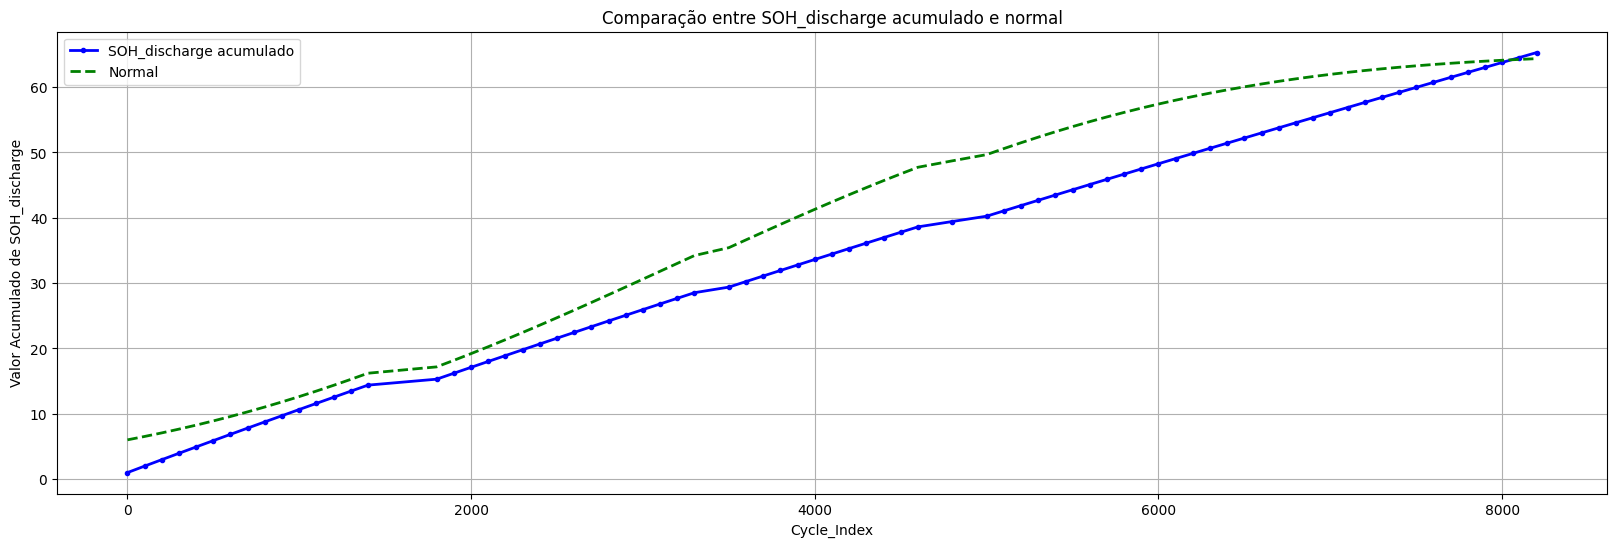

In [15]:
# gera um vetor x nos valores do seu eixo
x = np.linspace(df_grouped["SOH_discharge"].min(), df_grouped["SOH_discharge"].max(), len(df_grouped))

# calcula a CDF da normal nos pontos x
cdf = norm.cdf(x, loc=mean, scale=std)

# agora escala a CDF para o mesmo nível do acumulado real
expected_cumsum = cdf * (df_grouped["cum_SOH"].iloc[-1])

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_grouped["Cycle_Index"], df_grouped["cum_SOH"], label="SOH_discharge acumulado", color="blue", marker='.', linewidth=2)
ax.plot(df_grouped["Cycle_Index"], expected_cumsum, label="Normal", color="green", linestyle="--", linewidth=2)

ax.set_xlabel("Cycle_Index")
ax.set_ylabel("Valor Acumulado de SOH_discharge")
ax.set_title("Comparação entre SOH_discharge acumulado e normal")
ax.legend(loc='best')
ax.grid(True)

plt.show()